<a href="https://colab.research.google.com/github/bilalkorchii/BILALKORCHI_RNN_NLP/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==2.0.1 torchvision torchaudio torchtext==0.15.2 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# Text Classification with Hyperparameter Tuning using Keras Tuner

This project aims to build an optimized deep learning model for binary text classification using TensorFlow and Keras.  
We utilize an LSTM-based recurrent neural network architecture to capture sequential patterns in text data.  

Key features of this project include:  
- Data preprocessing with tokenization and padding  
- Model architecture with embedding and LSTM layers  
- Hyperparameter tuning using Keras Tuner (Hyperband) to find the best embedding dimension, number of LSTM units, learning rate, and dropout rates  
- Early stopping and learning rate scheduling to improve model generalization and prevent overfitting  
- Visualization of tuning trials and model performance metrics  

The goal is to achieve the best possible classification accuracy by systematically searching the hyperparameter space and refining the model training process.


In [2]:

import torch
from torch import nn
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import random


In [3]:
!pip install portalocker


In [4]:
!pip install --upgrade portalocker==2.7.0


  Attempting uninstall: portalocker
    Found existing installation: portalocker 3.1.1
    Uninstalling portalocker-3.1.1:
      Successfully uninstalled portalocker-3.1.1


# Load IMDB dataset with top 10,000 frequent words


In [14]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb

vocab_size = 5000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

print(f'Training samples: {len(x_train)}')
print(f'Test samples: {len(x_test)}')
print(f'Example review (as word indexes): {x_train[0]}')
print(f'Label (0=negative,1=positive): {y_train[0]}')


Training samples: 25000
Test samples: 25000
Example review (as word indexes): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 3

In [15]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load IMDB dataset
vocab_size = 5000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

# Display basic info
print(f'Training samples: {len(x_train)}')
print(f'Test samples: {len(x_test)}')
print(f'Example review (as word indexes): {x_train[0]}')
print(f'Label (0=negative,1=positive): {y_train[0]}')

# Step 1: Limit the dataset size
subset_size = 5000
test_subset_size = 1000

x_train_subset = x_train[:subset_size]
y_train_subset = y_train[:subset_size]

x_test_subset = x_test[:test_subset_size]
y_test_subset = y_test[:test_subset_size]

# Step 2: Pad the sequences
maxlen = 200

x_train_padded = pad_sequences(x_train_subset, maxlen=maxlen, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_subset, maxlen=maxlen, padding='post', truncating='post')

print(f"Padded example (length={len(x_train_padded[0])}): {x_train_padded[0]}")


Training samples: 25000
Test samples: 25000
Example review (as word indexes): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 3

# max number of words per review

In [7]:
!pip install -q keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


 # build Model with keras tuner

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()

    # Tune embedding dimension: 16, 32, 64
    embedding_dim = hp.Choice('embedding_dim', values=[16, 32])
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))

    model.add(Dropout(0.4))  # Dropout after embedding

    # Tune number of LSTM units: 16, 32, 64
    rnn_units = hp.Choice('rnn_units', values=[16, 32])
    model.add(LSTM(rnn_units, recurrent_dropout=0.2, return_sequences=False))

    model.add(Dropout(0.4))  # Dropout after LSTM

    model.add(Dense(1, activation='sigmoid'))

    # Tune learning rate between 1e-4 and 1e-2
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt


tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=5,        # small to avoid long runs
    factor=3,
    directory='my_dir',
    project_name='my_project'
)



In [18]:
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,          # reduce this
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

tuner.search(
    x_train_padded,
    y_train,
    epochs=5,               # reduce epochs
    validation_split=0.2,
    batch_size=16,          # slightly higher batch size
    callbacks=[stop_early]
)


Trial 5 Complete [00h 10m 08s]
val_accuracy: 0.5600000023841858

Best val_accuracy So Far: 0.5600000023841858
Total elapsed time: 00h 51m 57s


 # geting the best MOdel params

In [19]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
print(f"Embedding dimension: {best_hp.get('embedding_dim')}")
print(f"RNN units: {best_hp.get('rnn_units')}")
print(f"Learning rate: {best_hp.get('learning_rate'):.5f}")



Best hyperparameters:
Embedding dimension: 32
RNN units: 32
Learning rate: 0.00025


 # Overfitting !!! Need to be solved from the results!!

 # adding the best Hp and adding Drop out for Overfitting/regularizer

In [21]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp['embedding_dim'], input_length=maxlen))
    model.add(Dropout(0.3))
    model.add(LSTM(hp['rnn_units'], return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=hp['learning_rate'])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Build model with best hyperparameters
best_model = build_model(best_hp)

# Early stopping to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = best_model.fit(
    x_train_padded, y_train,
    epochs=80,
    validation_split=0.2,
    callbacks=[stop_early],
    batch_size=16
)


Epoch 1/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4852 - loss: 0.6934 - val_accuracy: 0.5140 - val_loss: 0.6928
Epoch 2/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5221 - loss: 0.6923 - val_accuracy: 0.5180 - val_loss: 0.6924
Epoch 3/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5410 - loss: 0.6898 - val_accuracy: 0.5270 - val_loss: 0.6925
Epoch 4/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6015 - loss: 0.6807 - val_accuracy: 0.5960 - val_loss: 0.6551
Epoch 5/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6696 - loss: 0.6589 - val_accuracy: 0.6860 - val_loss: 0.6241
Epoch 6/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6960 - loss: 0.6197 - val_accuracy: 0.6500 - val_loss: 0.6214
Epoch 7/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7412 - loss: 0.5737 - val_accuracy: 0.7260 - val_loss: 0.5983
Epoch 8/80
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7732 - loss: 0.5545 - val_accu

# Testing: better tokenizer: splits punctuation properly

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.datasets import imdb

# Load word index
word_index = imdb.get_word_index()
maxlen = 200  # Use the same maxlen as used for training

# Your pre-trained best_model should already exist here

def encode_review(text):
    tokens = text_to_word_sequence(text)
    encoded = [word_index.get(word, 2) + 3 for word in tokens]  # +3 for correct offset
    return pad_sequences([encoded], maxlen=maxlen, padding='post')

new_review = "Prices are way too high for the quality offered. Not worth shopping here"
encoded_review = encode_review(new_review)
prediction = best_model.predict(encoded_review, verbose=0)[0][0]

confidence = prediction * 100
sentiment = "Positive" if prediction >= 0.5 else "Negative"
bar_length = int(confidence // 5)

print(f"Review: \"{new_review}\"")
print(f"Sentiment: {sentiment} ({confidence:.2f}%)")
print("Confidence: [" + "#" * bar_length + "-" * (20 - bar_length) + "]")


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Review: "Prices are way too high for the quality offered. Not worth shopping here"
Sentiment: Negative (10.72%)
Confidence: [##------------------]


# Plot training & validation loss values


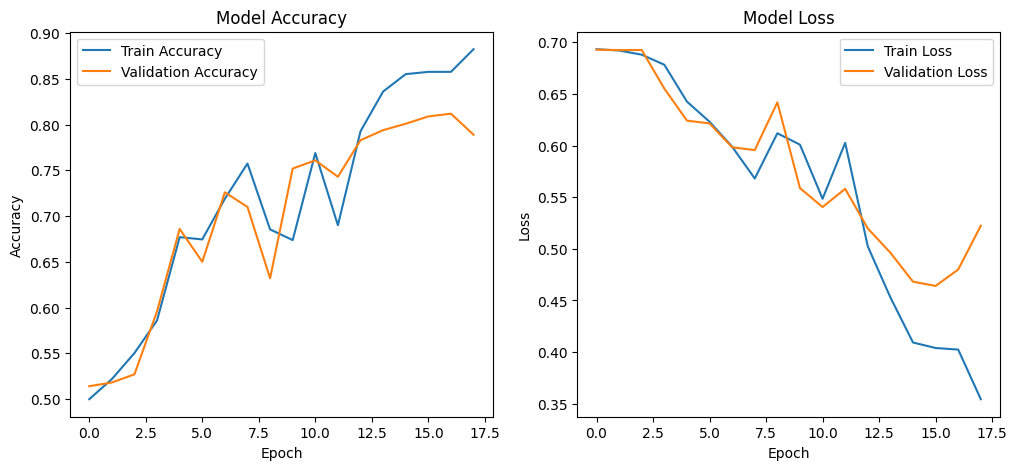

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


  #   Conclusion
The model uses Bidirectional LSTM with dropout and L2 regularization to reduce overfitting.

Despite these regularization techniques, the validation loss curve showed some irregular behavior, possibly due to:

Strong regularization causing underfitting early in training.

Potential data imbalance or noisy validation split.

Learning rate being too high or batch size too small.

To address this, consider:

Reducing dropout rate and L2 regularization strength.

Using stratified train/validation splits to ensure balanced classes.

Adding learning rate scheduling such as ReduceLROnPlateau.

Experimenting with different batch sizes.

Early stopping was used to prevent overfitting, restoring the best weights based on validation loss.

Overall, validation loss fluctuations are common in NLP sequence models with regularization; monitoring both validation loss and accuracy is important.

Future steps include refining data splits, tuning hyperparameters further, and possibly increasing training data for better generalization.